In [1]:
import keras_tuner
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from wittgenstein import RIPPER
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from sklearn.metrics import (make_scorer, accuracy_score, precision_score,
                             recall_score, f1_score, precision_recall_fscore_support, 
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

import keras
import keras_tuner

2024-01-07 14:45:56.002910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 14:45:56.002983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 14:45:56.071298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 14:45:56.224533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 14:45:57.974989: W tensorflow/compiler/tf2

# 1 Data Preprocessing

## 1.1 Handling categorical attirbute

In [25]:
original_dataset = pd.read_csv("data/final_dataset.csv")
original_dataset.head()

,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,851.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1553.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,18.0,28.0,37.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


In [26]:
state_cols = [n for n in original_dataset.columns if n.startswith('state')]
state_cols.remove('state_population')

original_dataset = original_dataset.drop(columns=state_cols)
original_dataset = original_dataset.drop(columns=['city_or_county', 'min_age_participants', 'max_age_participants'])

original_dataset.head()

,date,year,latitude,longitude,avg_age_participants,teen_ratio,adults_ratio,males_ratio,killed_ratio,injured_ratio,...,povertyPercentage,party,totalvotes,shooting,republicans_ratio,democrats_ratio,state_population,populous_city,month_x,month_y
0,851.0,2015.0,39.8322,-86.2492,19.0,0.0,1.0,1.0,0.0,1.0,...,12.3,0,112261.0,1,0.452677,0.547323,6611442,0,5.000000e-01,-0.866025
1,1553.0,2017.0,41.6645,-78.7856,62.0,0.0,1.0,1.0,1.0,0.0,...,10.5,1,307843.0,1,0.671644,0.328356,12794679,0,8.660254e-01,-0.500000
2,1404.0,2016.0,42.4190,-83.0393,28.0,0.0,1.0,1.0,0.0,0.5,...,11.0,0,310974.0,1,0.214934,0.785066,9954117,0,-5.000000e-01,0.866025
3,1383.0,2016.0,38.9030,-76.9820,28.0,0.0,1.0,1.0,0.0,1.0,...,14.9,1,296086.0,1,0.382615,0.617385,687576,0,-8.660254e-01,0.500000
4,894.0,2015.0,40.4621,-80.0308,28.0,0.0,1.0,1.0,0.0,0.5,...,11.5,0,148351.0,1,0.000000,1.000000,12789838,0,1.224647e-16,-1.000000


In [27]:
labels = original_dataset.pop('killed_ratio')
labels = (labels.to_numpy() > 0).astype('int')

In [28]:
_, count = np.unique(labels, return_counts=True)
print(count)
print(count[0] / (count[0] + count[1]))

[181580  57801]
0.7585397337299117


In [29]:
scaled_dataset = pd.DataFrame.copy(original_dataset).to_numpy()

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(scaled_dataset)
scaled_dataset

array([[-0.71291461, -0.57958268,  0.44287389, ...,  0.        ,
         0.68989202, -1.22704931],
       [ 0.87075273,  1.04955081,  0.79975723, ...,  0.        ,
         1.20385901, -0.7056087 ],
       [ 0.53461821,  0.23498407,  0.94671377, ...,  0.        ,
        -0.71429189,  1.24043416],
       ...,
       [ 1.17756008,  1.04955081, -0.47869655, ...,  0.        ,
        -1.22825888, -0.7056087 ],
       [ 0.19397181,  0.23498407,  0.24671757, ...,  0.        ,
        -0.01219994, -1.41790982],
       [ 0.2052515 ,  0.23498407,  0.44573706, ...,  0.        ,
        -0.01219994, -1.41790982]])

# 2 Utilities for measuring metrics scores

In [7]:
def report_metrics_best_estimator(train_label, train_pred, test_label, test_pred):
    print('Accuracy train set ', accuracy_score(train_label, train_pred))
    print('Accuracy test set ', accuracy_score(test_label, test_pred))
    print('Precision train set ', precision_score(train_label, train_pred, average='weighted'))
    print('Precision test set ', precision_score(test_label, test_pred, average='weighted'))
    print('Recall train set ', recall_score(train_label, train_pred, average='weighted'))
    print('Recall test set ', recall_score(test_label, test_pred, average='weighted'))
    print('F1 score train set ', f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set ', f1_score(test_label, test_pred, average='weighted'))
    print('Support train set ', precision_recall_fscore_support(train_label, train_pred))
    print('Support test set ', precision_recall_fscore_support(test_label, test_pred))

In [8]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label,
                                test_pred,
                                target_names=['No Killed', 'Killed']))

In [9]:
def report_confusion_matrix(test_label, test_pred):
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Killed', 'Killed'])
    disp.plot()
    plt.show()

# 3 Decision Tree

In [12]:
train_set, test_set, train_label, test_label = train_test_split(original_dataset, labels, stratify=labels, test_size=0.20)

undersample = RandomUnderSampler(sampling_strategy='majority')
train_set, train_label = undersample.fit_resample(train_set, train_label)

In [13]:
decision_tree = DecisionTreeClassifier()
param_dist = { "criterion": ["gini", "entropy"],
               "max_depth": [3, 5, 7, 10, None],
               "min_samples_split": sp_randint(20, 51),
               "min_samples_leaf": sp_randint(20, 51)}

random_search = RandomizedSearchCV(decision_tree, 
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   n_jobs=-1,
                                   scoring=make_scorer(accuracy_score))

random_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f922a696d40>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9229f6aa70>},
                   scoring=make_scorer(accuracy_score))

In [14]:
best_dt = random_search.best_estimator_
best_dt_hp = random_search.cv_results_['params'][0]
print('Best setting parameters ', best_dt_hp)
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 32}
Mean and std of this setting  0.8588374759593485 0.007497109022262077


In [15]:
train_pred = best_dt.predict(train_set)
test_pred = best_dt.predict(test_set)

In [16]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8812309422374084
Accuracy test set  0.8648620423167701
Precision train set  0.8823218010259951
Precision test set  0.8918330521870376
Recall train set  0.8812309422374084
Recall test set  0.8648620423167701
F1 score train set  0.8811461623785443
F1 score test set  0.8711485539128693
Support train set  (array([0.90274383, 0.86189978]), array([0.85452304, 0.90793884]), array([0.87797183, 0.8843205 ]), array([46241, 46241]))
Support test set  (array([0.96529791, 0.66103518]), array([0.85249332, 0.90371972]), array([0.90539553, 0.76355796]), array([36317, 11560]))


In [17]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.97      0.85      0.91     36317
      Killed       0.66      0.90      0.76     11560

    accuracy                           0.86     47877
   macro avg       0.81      0.88      0.83     47877
weighted avg       0.89      0.86      0.87     47877


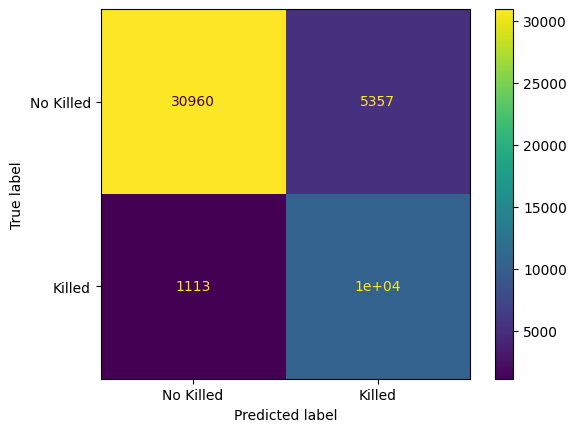

In [18]:
report_confusion_matrix(test_label, test_pred)

# 3 Random Forest

In [32]:
random_forest = RandomForestClassifier(n_estimators=10)
param_dist = {"max_depth": [3, 5, 7, 10, None],
              "max_features": sp_randint(1, train_set.shape[1] + 1),
              "min_samples_split": sp_randint(20, 51),
              "min_samples_leaf": sp_randint(20, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}

random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                 n_iter=10,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score))

random_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=10), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f922a0ff400>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9294815a50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9294815480>},
                   scoring=make_scorer(accuracy_score))

In [33]:
best_rf = random_search.best_estimator_
best_rf_hp = random_search.cv_results_['params'][0]
print('Best setting parameters ', best_rf_hp)
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 19, 'min_samples_leaf': 43, 'min_samples_split': 41}
Mean and std of this setting  0.8727211427767301 0.0017378577526551353


In [34]:
train_pred = best_rf.predict(train_set)
test_pred = best_rf.predict(test_set)

In [35]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8848316429142968
Accuracy test set  0.8684336946759404
Precision train set  0.885880685278297
Precision test set  0.8954090880537743
Recall train set  0.8848316429142968
Recall test set  0.8684336946759404
F1 score train set  0.884753316466544
F1 score test set  0.8745832587984534
Support train set  (array([0.90600046, 0.86576091]), array([0.8587617 , 0.91090158]), array([0.88174884, 0.88775779]), array([46241, 46241]))
Support test set  (array([0.96838722, 0.66614034]), array([0.85444833, 0.91237024]), array([0.90785682, 0.77005074]), array([36317, 11560]))


In [36]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.97      0.85      0.91     36317
      Killed       0.67      0.91      0.77     11560

    accuracy                           0.87     47877
   macro avg       0.82      0.88      0.84     47877
weighted avg       0.90      0.87      0.87     47877


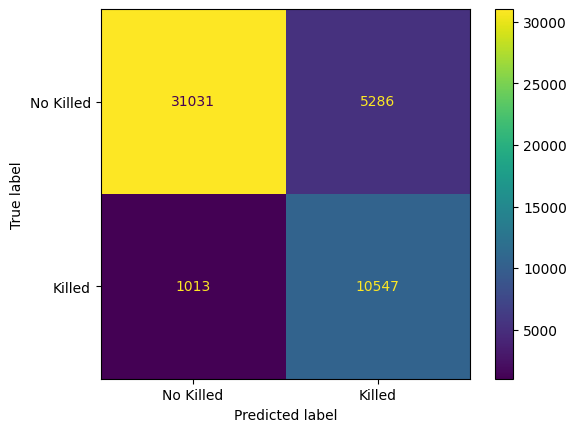

In [37]:
report_confusion_matrix(test_label, test_pred)

# 4 RIPPER

In [65]:
ripper = RIPPER()
param_dist = {"prune_size": [0.5, 0.6, 0.7], "k": [1, 3, 5]}

grid_search = GridSearchCV(ripper, 
                           param_grid=param_dist,
                           n_jobs=-1,
                           scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

GridSearchCV(estimator=<RIPPER(verbosity=0, max_rule_conds=None, alpha=1.0, max_total_conds=None, k=2, dl_allowance=64, random_state=None, max_rules=None, prune_size=0.33, n_discretize_bins=10)>,
             n_jobs=-1,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6, 0.7]},
             scoring=make_scorer(accuracy_score))

In [66]:
best_ripper = grid_search.best_estimator_
best_ripper_hp = grid_search.cv_results_['params'][0]
print('Best setting parameters ', best_ripper_hp)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'k': 1, 'prune_size': 0.5}
Mean and std of this setting  0.8628604382929643 0.002879755345731601


In [67]:
train_pred = best_ripper.predict(train_set)
test_pred = best_ripper.predict(test_set)

In [68]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8648212226066897
Accuracy test set  0.8590892001408392
Precision train set  0.864831943979016
Precision test set  0.8810139003638359
Recall train set  0.8648212226066897
Recall test set  0.8590892001408392
F1 score train set  0.8648202294695243
F1 score test set  0.8648892965530991
Support train set  (array([0.8668097 , 0.86285419]), array([0.86211073, 0.86753172]), array([0.86445383, 0.86518663]), array([17340, 17340]))
Support test set  (array([0.95171005, 0.65892584]), array([0.85775652, 0.86327575]), array([0.90229409, 0.74738419]), array([127106,  40461]))


In [69]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.95      0.86      0.90    127106
      Killed       0.66      0.86      0.75     40461

    accuracy                           0.86    167567
   macro avg       0.81      0.86      0.82    167567
weighted avg       0.88      0.86      0.86    167567


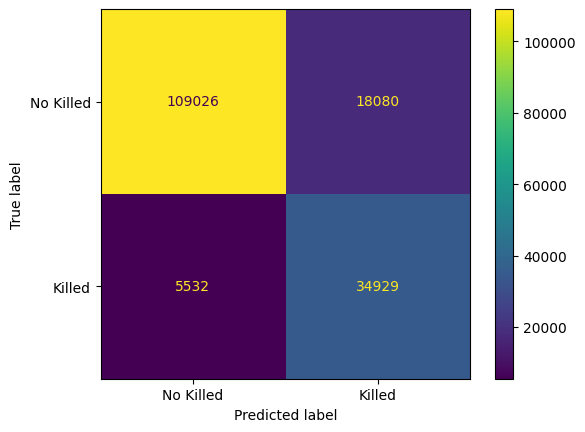

In [70]:
report_confusion_matrix(test_label, test_pred)

# 5 K-nn

In [38]:
train_set, test_set, train_label, test_label = train_test_split(scaled_dataset, labels, stratify=labels, test_size=0.20)

undersample = RandomUnderSampler(sampling_strategy='majority')
train_set, train_label = undersample.fit_resample(train_set, train_label)

In [50]:
knn = KNeighborsClassifier(algorithm='ball_tree', metric='minkowski')
param_dist = {"n_neighbors": [1, 3, 5, 10, 20]}

grid_search = GridSearchCV(knn, param_grid=param_dist,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

GridSearchCV(estimator=KNeighborsClassifier(algorithm='ball_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]},
             scoring=make_scorer(accuracy_score))

In [51]:
best_knn = grid_search.best_estimator_
best_knn_hp = grid_search.cv_results_['params'][0]
print('Best setting parameters ', best_knn_hp)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'n_neighbors': 1}
Mean and std of this setting  0.8108929142488831 0.0018195724678868573


In [52]:
train_pred = best_knn.predict(train_set)
test_pred = best_knn.predict(test_set)

In [53]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8653143314374689
Accuracy test set  0.8282891576331015
Precision train set  0.8679859177383837
Precision test set  0.8739210505357132
Recall train set  0.8653143314374689
Recall test set  0.8282891576331015
F1 score train set  0.8650694316732797
F1 score test set  0.8382003534442571
Support train set  (array([0.89934044, 0.83663139]), array([0.82271145, 0.90791722]), array([0.859321  , 0.87081786]), array([46241, 46241]))
Support test set  (array([0.9625922 , 0.59535096]), array([0.8049123, 0.9017301]), array([0.8767189 , 0.71719013]), array([36317, 11560]))


In [54]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.96      0.80      0.88     36317
      Killed       0.60      0.90      0.72     11560

    accuracy                           0.83     47877
   macro avg       0.78      0.85      0.80     47877
weighted avg       0.87      0.83      0.84     47877


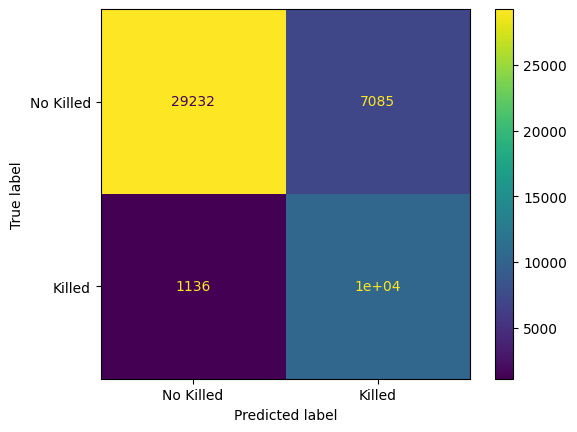

In [55]:
report_confusion_matrix(test_label, test_pred)

# 6 Naive Bayes

In [25]:
naiveBayes = GaussianNB()

#run the grid search
naiveBayes.fit(train_set, train_label)

GaussianNB()

In [26]:
train_pred = naiveBayes.predict(train_set)
test_pred = naiveBayes.predict(test_set)

In [27]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8473865184576458
Accuracy test set  0.858428890699083
Precision train set  0.8477398602496827
Precision test set  0.8751408513670618
Recall train set  0.8473865184576458
Recall test set  0.858428890699083
F1 score train set  0.8473477406030917
F1 score test set  0.8633662398235818
Support train set  (array([0.83665514, 0.85882458]), array([0.86332476, 0.83144828]), array([0.84978075, 0.84491473]), array([46241, 46241]))
Support test set  (array([0.9418963 , 0.66542134]), array([0.86683922, 0.83200692]), array([0.90281044, 0.73944799]), array([36317, 11560]))


In [28]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.94      0.87      0.90     36317
      Killed       0.67      0.83      0.74     11560

    accuracy                           0.86     47877
   macro avg       0.80      0.85      0.82     47877
weighted avg       0.88      0.86      0.86     47877


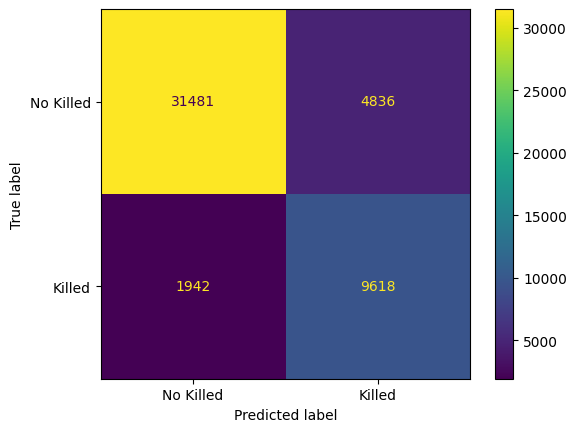

In [29]:
report_confusion_matrix(test_label, test_pred)

# 7 SVC

In [58]:
svc = SVC()
param_dist = {"C": [1e-1, 1, 10],
              "kernel": ["rbf", "linear", "poly"]}


grid_search = GridSearchCV(svc, param_grid=param_dist,
                                n_jobs=-1,
                                scoring=make_scorer(accuracy_score))

grid_search.fit(train_set, train_label)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring=make_scorer(accuracy_score))

In [59]:
best_svc = grid_search.best_estimator_
best_svc_hp = grid_search.cv_results_['params'][0]
print('Best setting parameters ', best_svc_hp)
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'C': 0.1, 'kernel': 'rbf'}
Mean and std of this setting  0.8675028835063439 0.0022016850252388753


In [60]:
train_pred = best_svc.predict(train_set)
test_pred = best_svc.predict(test_set)

In [61]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.881199538638985
Accuracy test set  0.862126791074615
Precision train set  0.8818652547855311
Precision test set  0.8878428685673942
Recall train set  0.881199538638985
Recall test set  0.862126791074615
F1 score train set  0.8811477390393989
F1 score test set  0.8683576380263659
Support train set  (array([0.89780934, 0.86592117]), array([0.86032295, 0.90207612]), array([0.87866651, 0.88362897]), array([17340, 17340]))
Support test set  (array([0.9608142 , 0.65860746]), array([0.85302818, 0.89070957]), array([0.90371864, 0.75727299]), array([127106,  40461]))


In [62]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.96      0.85      0.90    127106
      Killed       0.66      0.89      0.76     40461

    accuracy                           0.86    167567
   macro avg       0.81      0.87      0.83    167567
weighted avg       0.89      0.86      0.87    167567


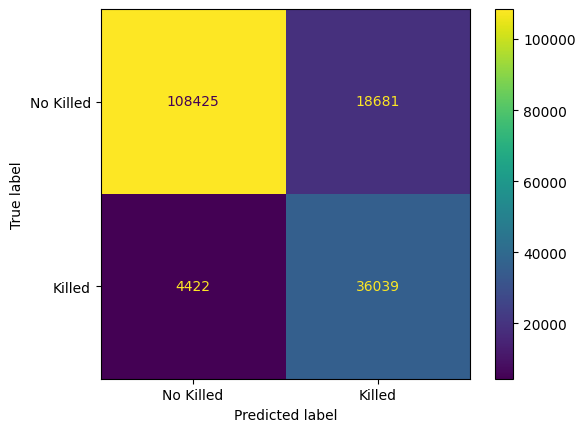

In [63]:
report_confusion_matrix(test_label, test_pred)

# 8 Neural Network

In [30]:
train_set, val_set, train_label, val_label = train_test_split(train_set, train_label, stratify=train_label, test_size=0.20)

In [31]:
def build_model(hp):
    activation_f = hp.Choice('activation', ['tanh', 'sigmoid', 'relu'])
    max_layer = 5
    units_per_layer = []
    
    for i in range(max_layer - 1):
        units_per_layer.append(hp.Int('units_' + str(i), min_value=5, max_value=50, step=5))
    
    model = keras.Sequential()

    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', min_value=2, max_value=max_layer, step=1) - 1):
        model.add(keras.layers.Dense(units=units_per_layer[i],
                               activation=activation_f))

    # Output layer with a single unit and sigmoid activation (for binary classification)
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.5, 0.1, 0.001, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [33]:
tuner = keras_tuner.RandomSearch(build_model,
                                 objective='val_accuracy',
                                 max_trials=15,
                                 directory='nn_tuning',
                                 project_name='sequential_classifier')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(train_set, train_label,
             epochs=100,
             batch_size=1000,
             callbacks=[early_stopping],
             validation_data=(val_set, val_label))

Trial 15 Complete [00h 00m 13s]
val_accuracy: 0.8080229163169861

Best val_accuracy So Far: 0.878466784954071
Total elapsed time: 00h 02m 36s


In [37]:
best_nn_hp = tuner.get_best_hyperparameters()[0]
best_nn = build_model(best_nn_hp)

history = best_nn.fit(train_set, train_label,
                      epochs=100,
                      batch_size=1000,
                      callbacks=[early_stopping],
                      validation_data=(val_set, val_label))

Epoch 1/100
74/74 [==============================] - 1s 3ms/step - loss: 0.3830 - accuracy: 0.8328 - val_loss: 0.3144 - val_accuracy: 0.8633
Epoch 2/100
74/74 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8699 - val_loss: 0.2966 - val_accuracy: 0.8707
Epoch 3/100
74/74 [==============================] - 0s 2ms/step - loss: 0.2938 - accuracy: 0.8749 - val_loss: 0.2920 - val_accuracy: 0.8723
Epoch 4/100
74/74 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8767 - val_loss: 0.2921 - val_accuracy: 0.8708
Epoch 5/100
74/74 [==============================] - 0s 2ms/step - loss: 0.2855 - accuracy: 0.8782 - val_loss: 0.2886 - val_accuracy: 0.8766
Epoch 6/100
74/74 [==============================] - 0s 2ms/step - loss: 0.2834 - accuracy: 0.8788 - val_loss: 0.2865 - val_accuracy: 0.8746
Epoch 7/100
74/74 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8785 - val_loss: 0.2881 - val_accuracy: 0.8738
Epoch 8/100
7

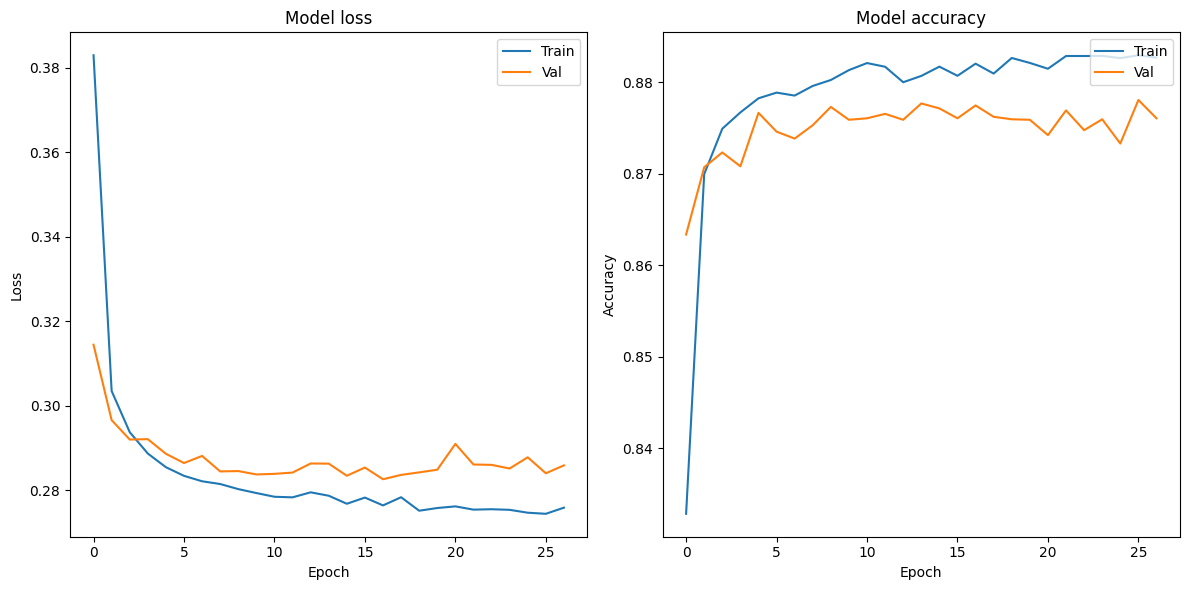

In [38]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper right')

plt.tight_layout()
plt.show()

In [39]:
print('Best setting parameters ', tuner.get_best_hyperparameters()[0].values)

Best setting parameters  {'activation': 'sigmoid', 'units_0': 45, 'units_1': 45, 'units_2': 15, 'units_3': 30, 'num_layers': 2, 'learning_rate': 0.1}


In [41]:
best_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 45)                945       
                                                                 
 dense_4 (Dense)             (None, 1)                 46        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
train_pred = best_nn(train_set) > 0.5
test_pred = best_nn(test_set) > 0.5

In [43]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8848955869432993
Accuracy test set  0.8659063851118491
Precision train set  0.8864206158480328
Precision test set  0.8940809530091512
Recall train set  0.8848955869432993
Recall test set  0.8659063851118491
F1 score train set  0.8847818522925917
F1 score test set  0.872294620867551
Support train set  (array([0.91069574, 0.86214615]), array([0.85348183, 0.91630849]), array([0.88116104, 0.88840257]), array([36992, 36993]))
Support test set  (array([0.96823806, 0.66110832]), array([0.85114409, 0.91228374]), array([0.90592304, 0.76664728]), array([36317, 11560]))


In [44]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.97      0.85      0.91     36317
      Killed       0.66      0.91      0.77     11560

    accuracy                           0.87     47877
   macro avg       0.81      0.88      0.84     47877
weighted avg       0.89      0.87      0.87     47877


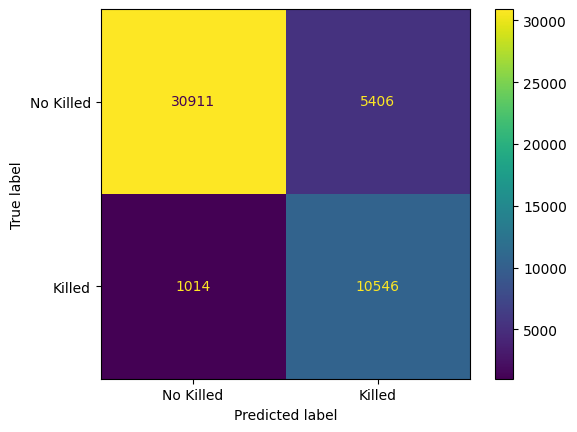

In [45]:
report_confusion_matrix(test_label, test_pred)

# Adaboost with decision tree

In [19]:
train_set, test_set, train_label, test_label = train_test_split(original_dataset, labels, stratify=labels, test_size=0.20)

undersample = RandomUnderSampler(sampling_strategy='majority')
train_set, train_label = undersample.fit_resample(train_set, train_label)

In [20]:
ada_boost = AdaBoostClassifier(estimator=DecisionTreeClassifier(**best_dt_hp), n_estimators=100, learning_rate=0.1)
ada_boost.fit(train_set, train_label)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf=50,
                                                    min_samples_split=32),
                   learning_rate=0.1, n_estimators=100)

In [21]:
train_pred = ada_boost.predict(train_set)
test_pred = ada_boost.predict(test_set)

In [22]:
report_metrics_best_estimator(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8892324992971605
Accuracy test set  0.868454581531842
Precision train set  0.8903139351651836
Precision test set  0.8956255577910978
Recall train set  0.8892324992971605
Recall test set  0.868454581531842
F1 score train set  0.8891557207295969
F1 score test set  0.8746262203080425
Support train set  (array([0.910859  , 0.86976888]), array([0.86291386, 0.91555113]), array([0.88623845, 0.89207299]), array([46241, 46241]))
Support test set  (array([0.96873926, 0.66593088]), array([0.85414544, 0.9134083 ]), array([0.90784044, 0.77028013]), array([36317, 11560]))


In [23]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

   No Killed       0.97      0.85      0.91     36317
      Killed       0.67      0.91      0.77     11560

    accuracy                           0.87     47877
   macro avg       0.82      0.88      0.84     47877
weighted avg       0.90      0.87      0.87     47877


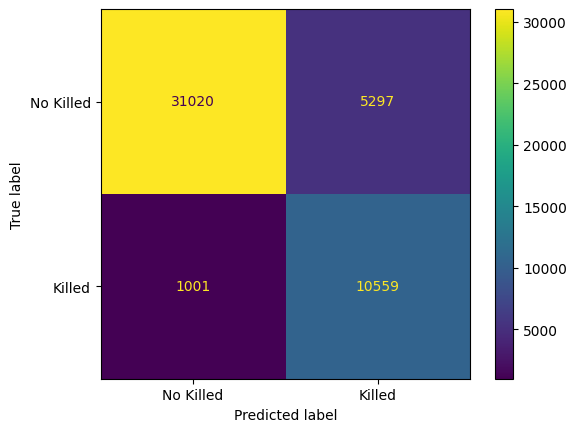

In [24]:
report_confusion_matrix(test_label, test_pred)